In [1]:
#Tratamieto de datos
import pandas as pd #
import numpy as np  #
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [3]:
data1 = data.drop(["PBA", "CF", "Indicador", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)

In [4]:
data1["Rechazados_Binario"] = data1["Rechazados"] 
data1.loc[data1["Rechazados_Binario"] > 0, "Rechazados_Binario"] = 1
print(data1.Rechazados_Binario.value_counts().sort_index())


0    1329
1     585
Name: Rechazados_Binario, dtype: int64


# Umbral de Clasificación Esperado
En el 69.4% de las maduraciones No se rechazan canales y en el 30.6% sí se rechazan. Un modelo de clasificación que sea útil debe de ser capaz de predecir correctamente un porcentaje de observaciones por encima del porcentaje de la clase mayoritaria. En este caso, el umbral de referencia que se tiene que superar es del 69.4%.

In [5]:
###VARIABLES CATEGORICAS Y NUMERICAS
features = list(set(data1.columns.values) - set(['ID', 'TARGET']))
cat_features = [feat for feat in features if data1[feat].dtype.name in ['category', 'object']]
num_features = list(set(features) - set(cat_features))

print(f"Factores Categoricos: \n {cat_features}")
print(f"Factores Numéricos: \n {num_features}")

Factores Categoricos: 
 ['Franja2', 'pH_Requisito', 'Franja1', 'Dia_Semana', 'Refrigeracion', 'TIPO_CAP_CF']
Factores Numéricos: 
 ['Rechazados_Binario', 'Tamin', 'Ocupacion', 'Temp1', 'Canales', 'Ti1', 'PPPCF', 'VT2', 'Taamax', 'Temp3', 'VT1', 'Temp2', 'Rechazados', 'Ti2']


In [6]:
data1.isnull().sum() #Datos faltantes

Dia_Semana             0
Temp1                  0
Franja1                0
Temp2                  0
Franja2                0
VT1                    0
Ti1                    0
Temp3                  0
Ti2                    0
VT2                    0
Refrigeracion          0
Canales                0
PPPCF                  0
Ocupacion              0
pH_Requisito           0
Tamin                 29
Taamax                29
TIPO_CAP_CF            0
Rechazados             0
Rechazados_Binario     0
dtype: int64

In [7]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [8]:
data1.describe()

,Temp1,Temp2,VT1,Ti1,Temp3,Ti2,VT2,Canales,PPPCF,Ocupacion,Tamin,Taamax,Rechazados,Rechazados_Binario
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,3.080371,11.733454,8.653083,2.129855,2.766437,33.368273,-8.955836,136.827586,22.518286,93.083697,23.857913,32.530543,0.552247,0.305643
std,1.614204,3.365969,3.251896,1.135182,1.774718,14.483894,3.597810,30.208935,15.420267,11.038884,0.960839,1.664524,0.930765,0.460799
min,-4.700000,1.400000,-3.200000,0.166667,-5.600000,24.000000,-35.200000,27.000000,3.991370,19.354839,20.400000,27.200000,0.000000,0.000000
25%,2.100000,10.000000,6.800000,1.583333,2.000000,24.250000,-10.900000,140.000000,17.022934,91.888046,23.300000,31.600000,0.000000,0.000000
50%,2.900000,11.500000,8.500000,1.883333,3.000000,25.250000,-9.000000,150.000000,19.326683,96.774194,24.000000,32.600000,0.000000,0.000000
75%,3.900000,13.800000,10.500000,2.483333,3.800000,37.757500,-7.000000,155.000000,23.219814,100.000000,24.500000,33.600000,1.000000,1.000000
max,18.200000,39.400000,36.800000,16.183333,7.300000,110.200000,4.200000,239.000000,100.000000,104.761905,26.000000,36.300000,5.000000,1.000000


In [9]:
data1.Temp3.unique

<bound method Series.unique of 0       4.0
1       4.0
2       4.4
3       4.3
4       5.4
       ... 
1909    3.0
1910    1.3
1911    1.8
1912    0.9
1913   -1.4
Name: Temp3, Length: 1914, dtype: float64>

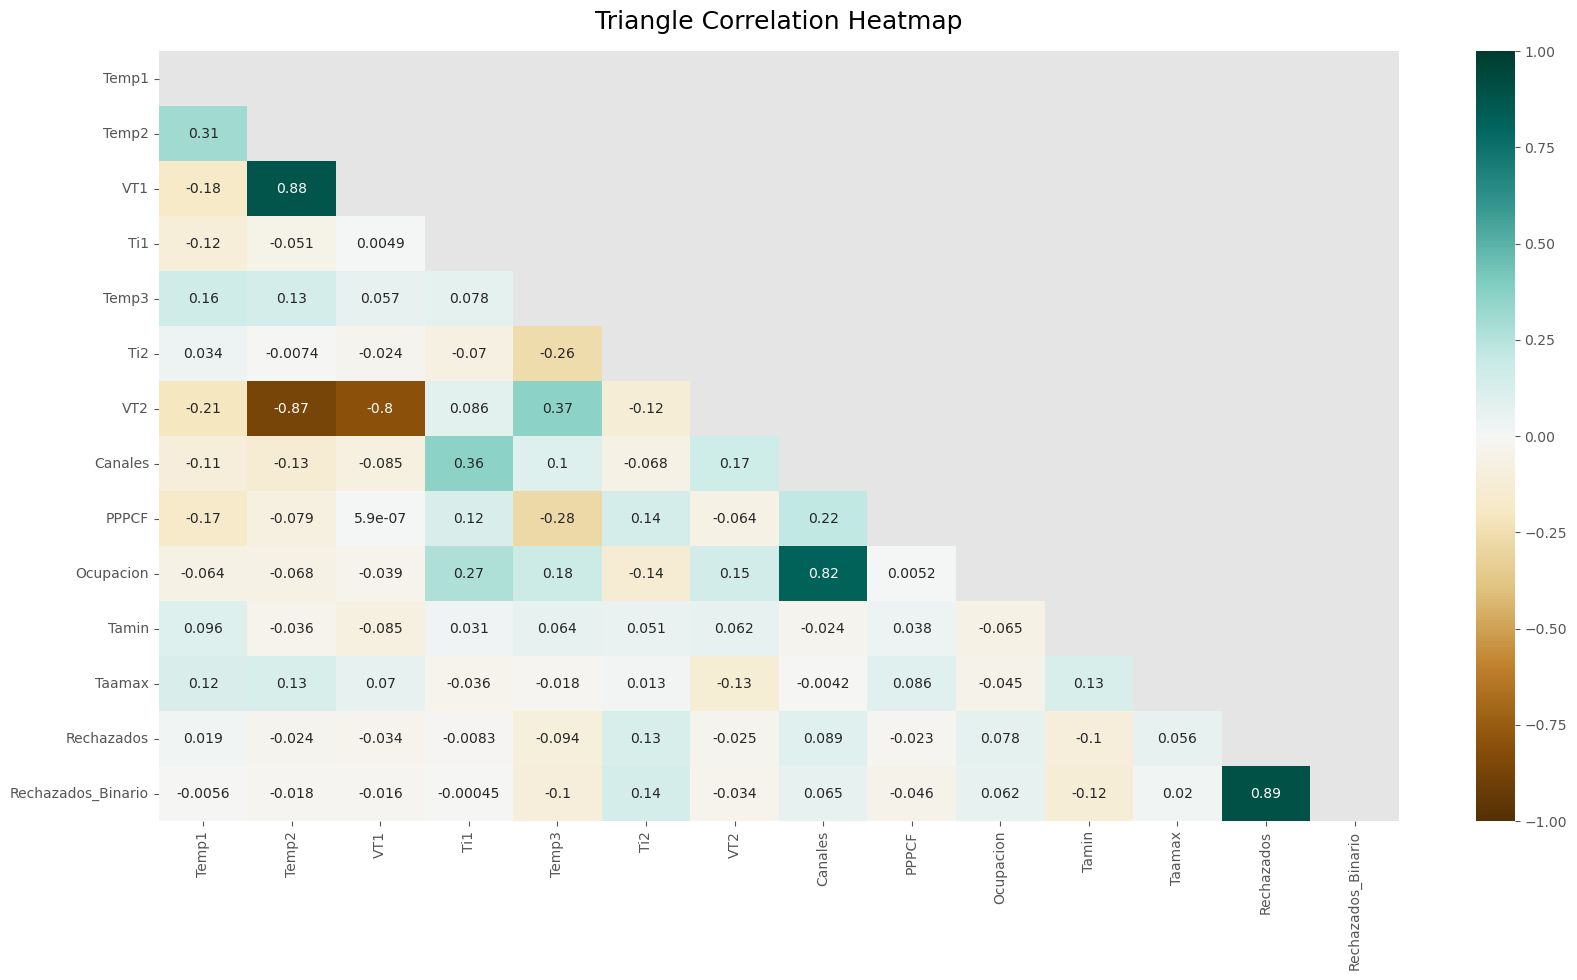

In [10]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(data1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [11]:
data1 = data1.drop(["VT1", "VT2", "Rechazados", "Canales"], axis=1)

In [12]:
data1 = pd.get_dummies(data1, drop_first = True, columns = ["Franja1", "Franja2", "Dia_Semana"]) # el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

In [13]:
data1.columns

Index(['Temp1', 'Temp2', 'Ti1', 'Temp3', 'Ti2', 'PPPCF', 'Ocupacion', 'Tamin',
       'Taamax', 'Rechazados_Binario', 'Franja1_MAÑANA', 'Franja1_MEDIO_DIA',
       'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA', 'Franja2_MEDIO_DIA',
       'Franja2_NOCHE', 'Franja2_TARDE', 'Dia_Semana_lunes',
       'Dia_Semana_martes', 'Dia_Semana_miércoles', 'Dia_Semana_sábado',
       'Dia_Semana_viernes', 'Refrigeracion_AMONIACO', 'Refrigeracion_GLICOL',
       'pH_Requisito_Mi_5.8', 'pH_Requisito_Mi_6', 'TIPO_CAP_CF_C1',
       'TIPO_CAP_CF_C2', 'TIPO_CAP_CF_C3', 'TIPO_CAP_CF_PBA2'],
      dtype='object')

In [14]:
print("Capacidad Tipo 1:", data1.TIPO_CAP_CF_C1.sum(),'\n',
      "Capacidad Tipo 2:", data1.TIPO_CAP_CF_C2.sum(),'\n',
      "Capacidad Tipo 3:", data1.TIPO_CAP_CF_C3.sum(),'\n',
      "Capacidad Frigosinú:", data1.TIPO_CAP_CF_PBA2.sum())

Capacidad Tipo 1: 187 
 Capacidad Tipo 2: 124 
 Capacidad Tipo 3: 1531 
 Capacidad Frigosinú: 72


In [15]:
data1 = data1.drop(["Refrigeracion_GLICOL", "pH_Requisito_Mi_6", "TIPO_CAP_CF_PBA2"], axis=1)

In [16]:
data1 = sm.add_constant(data1)
modelo=sm.Logit(data1["Rechazados_Binario"],data1.drop(["Rechazados_Binario"], axis=1))
modelo=modelo.fit()
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.562399
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1886
Method:                           MLE   Df Model:                           27
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                 0.08638
Time:                        19:37:34   Log-Likelihood:                -1076.4
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 5.260e-29
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0517      2.175     -0.024      0.981      -4.315       4.212
Temp1                     -0.0371      0.039     -0.956      0.339      -0.113       0.039
Temp2                     -0.0034      0.018     -0.192      0.847      -0.039       0.032
Ti1                       -0.0290      0.060     -0.485      0.628      -0.146       0.088
Temp3                     -0.1462      0.033     -4.433      0.000      -0.211      -0.082
Ti2                        0.0240      0.004      5.854      0.000       0.016       0.032
PPPCF                      0.0143      0.009      1.618      0.106      -0.003       0.032
Ocupacion                  0.0074      0.007      1.041      0.298      -0.007       0.021
Tamin                     -0.3094      0.056     -5.539      0.000      -0.419      -0.200
Taamax                     0.0663      0.033      2.010      0.044       0.002       0.131
Franja1_MAÑANA            -0.6371      0.906     -0.703      0.482      -2.414       1.140
Franja1_MEDIO_DIA         -0.4849      0.888     -0.546      0.585      -2.225       1.256
Franja1_NOCHE             -0.6869      0.865     -0.794      0.427      -2.383       1.009
Franja1_TARDE             -0.6660      0.878     -0.759      0.448      -2.386       1.054
Franja2_MAÑANA            -0.8757      0.589     -1.486      0.137      -2.031       0.279
Franja2_MEDIO_DIA         -0.7412      0.563     -1.316      0.188      -1.845       0.363
Franja2_NOCHE             -0.6829      0.462     -1.478      0.139      -1.588       0.223
Franja2_TARDE             -0.4796      0.486     -0.986      0.324      -1.433       0.474
Dia_Semana_lunes           0.2873      0.186      1.547      0.122      -0.077       0.651
Dia_Semana_martes          0.2574      0.178      1.447      0.148      -0.091       0.606
Dia_Semana_miércoles       0.2270      0.178      1.275      0.202      -0.122       0.576
Dia_Semana_sábado         -0.2258      0.189     -1.198      0.231      -0.595       0.144
Dia_Semana_viernes        -0.4310      0.196     -2.201      0.028      -0.815      -0.047
Refrigeracion_AMONIACO     0.1251      0.128      0.978      0.328      -0.126       0.376
pH_Requisito_Mi_5.8        0.4420      0.130      3.400      0.001       0.187       0.697
TIPO_CAP_CF_C1             3.8949      1.071      3.635      0.000       1.795       5.995
TIPO_CAP_CF_C2             4.0832      1.049      3.894      0.000       2.028       6.138
TIPO_CAP_CF_C3             4.1397      0.978      4.233      0.000       2.223       6.057
==========================================================================================
"""

In [17]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Binario"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Binario"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Binario"], axis=1).columns)              

const                     1514.556230
Temp1                        1.259138
Temp2                        1.285794
Ti1                          1.505831
Temp3                        1.286710
Ti2                          1.310146
PPPCF                        4.670672
Ocupacion                    1.843314
Tamin                        1.069315
Taamax                       1.090818
Franja1_MAÑANA              61.402552
Franja1_MEDIO_DIA           43.562592
Franja1_NOCHE               31.775524
Franja1_TARDE               69.290192
Franja2_MAÑANA               9.951593
Franja2_MEDIO_DIA           16.074786
Franja2_NOCHE               14.950315
Franja2_TARDE               20.890377
Dia_Semana_lunes             1.698144
Dia_Semana_martes            1.711234
Dia_Semana_miércoles         1.716613
Dia_Semana_sábado            1.794395
Dia_Semana_viernes           1.754715
Refrigeracion_AMONIACO       1.535153
pH_Requisito_Mi_5.8          1.167913
TIPO_CAP_CF_C1              15.188822
TIPO_CAP_CF_

In [18]:
#Eliminando la Multicolinealidad
data1 = data1.drop([ "Franja1_MAÑANA", "Franja1_MEDIO_DIA","Franja1_NOCHE", "Franja1_TARDE", "Franja2_TARDE", "TIPO_CAP_CF_C3"], axis=1)

In [19]:
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Binario"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Binario"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Binario"], axis=1).columns)        

const                     1148.411297
Temp1                        1.215052
Temp2                        1.240060
Ti1                          1.227530
Temp3                        1.249140
Ti2                          1.243720
PPPCF                        1.502551
Ocupacion                    1.777782
Tamin                        1.062404
Taamax                       1.077592
Franja2_MAÑANA               1.167011
Franja2_MEDIO_DIA            1.217225
Franja2_NOCHE                1.221952
Dia_Semana_lunes             1.692941
Dia_Semana_martes            1.702729
Dia_Semana_miércoles         1.711361
Dia_Semana_sábado            1.759828
Dia_Semana_viernes           1.745446
Refrigeracion_AMONIACO       1.525699
pH_Requisito_Mi_5.8          1.136335
TIPO_CAP_CF_C1               2.063130
TIPO_CAP_CF_C2               1.242790
dtype: float64

In [20]:
#Nuevo modelo
model=sm.Logit(data1["Rechazados_Binario"],data1.drop(["Rechazados_Binario"], axis=1))
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.570467
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1892
Method:                           MLE   Df Model:                           21
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                 0.07327
Time:                        19:37:34   Log-Likelihood:                -1091.9
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 7.904e-26
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.8311      1.781      1.590      0.112      -0.660       6.322
Temp1                     -0.0029      0.036     -0.078      0.938      -0.074       0.069
Temp2                     -0.0100      0.017     -0.577      0.564      -0.044       0.024
Ti1                       -0.0330      0.053     -0.618      0.537      -0.138       0.072
Temp3                     -0.1252      0.032     -3.898      0.000      -0.188      -0.062
Ti2                        0.0284      0.004      7.091      0.000       0.021       0.036
PPPCF                     -0.0187      0.005     -3.594      0.000      -0.029      -0.008
Ocupacion                  0.0113      0.007      1.650      0.099      -0.002       0.025
Tamin                     -0.2885      0.055     -5.220      0.000      -0.397      -0.180
Taamax                     0.0593      0.033      1.824      0.068      -0.004       0.123
Franja2_MAÑANA            -0.4693      0.199     -2.359      0.018      -0.859      -0.079
Franja2_MEDIO_DIA         -0.3295      0.151     -2.186      0.029      -0.625      -0.034
Franja2_NOCHE             -0.3555      0.132     -2.687      0.007      -0.615      -0.096
Dia_Semana_lunes           0.2684      0.184      1.457      0.145      -0.093       0.629
Dia_Semana_martes          0.2591      0.177      1.467      0.142      -0.087       0.605
Dia_Semana_miércoles       0.2076      0.177      1.175      0.240      -0.139       0.554
Dia_Semana_sábado         -0.3258      0.187     -1.745      0.081      -0.692       0.040
Dia_Semana_viernes        -0.4886      0.196     -2.498      0.012      -0.872      -0.105
Refrigeracion_AMONIACO     0.1198      0.127      0.941      0.347      -0.130       0.369
pH_Requisito_Mi_5.8        0.5393      0.130      4.149      0.000       0.284       0.794
TIPO_CAP_CF_C1            -0.5441      0.269     -2.022      0.043      -1.072      -0.017
TIPO_CAP_CF_C2            -0.2950      0.242     -1.219      0.223      -0.769       0.179
==========================================================================================
"""

## Predicción y AIC con todas las variables 

### Matriz de Confusión

Una matriz de confusión es una herramienta para resumir el rendimiento de un algoritmo de clasificación. Una matriz de confusión nos dará una imagen clara del rendimiento del modelo de clasificación y los tipos de errores producidos por el modelo. Nos da un resumen de predicciones correctas e incorrectas desglosadas por cada categoría. El resumen se representa en forma tabular.


- Verdaderos positivos (VP): los verdaderos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase y la observación en realidad pertenece a esa clase.

- Verdaderos negativos (VN): los verdaderos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase y la observación en realidad no pertenece a esa clase.

- Falsos positivos (FP): los falsos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase, pero la observación en realidad no pertenece a esa clase. Este tipo de error se denomina error tipo I.

- Falsos negativos (FN): los falsos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase, pero la observación en realidad pertenece a esa clase. Este es un error muy grave y se llama error de tipo II.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5704670797787682
            Iterations: 103
            Function evaluations: 111
            Gradient evaluations: 103


<AxesSubplot:>

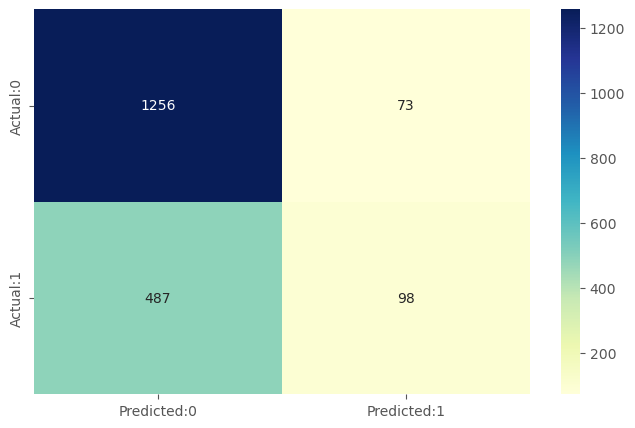

In [21]:
from sklearn.metrics import confusion_matrix
res= model.fit_regularized()
#accuracy = accuracy_score(y_true = data1["Rechazados_Binario"], y_pred = np.where(res.predict(data1.drop(["Rechazados_Binario"], axis=1)) <0.5, 0, 1), normalize = True)
cm=confusion_matrix(data1["Rechazados_Binario"],np.where(result.predict(data1.drop(["Rechazados_Binario"], axis=1)) <0.5, 0, 1))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [22]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(data1["Rechazados_Binario"],np.where(res.predict(data1.drop(["Rechazados_Binario"], axis=1)) <0.5, 0, 1))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
#plt.figure(figsize = (8,5))
#sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
VN = cm[1,1]
VP = cm[0,0]
FN = cm[1,0]
FP = cm[0,1] 
accuracy = (VP+VN)/(VP+VN+FP+FN) #Acurracy
Precision = VP / float(VP+FP)
Recall_Sencibilidad = VP/float(VP+FN)
Especificidad = VN/float(VN+FP)
F1_Score = (2*Precision*Recall_Sencibilidad) / float(Precision+Recall_Sencibilidad)

In [23]:
Metricas = pd.DataFrame([["Todas", res.aic.round(1), (100*accuracy).round(1), (100*Recall_Sencibilidad).round(1), (100*Especificidad).round(1), (100*Precision).round(1), (100*F1_Score).round(1) ], [0, 0, 0, 0, 0, 0, 0]], columns=['Variables del Modelo', 'AIC', '% Accuracy', '% Recall_Sencibilidad', 'Especificidad', 'Precisión', 'F1_Score'])

## Solo Variables Significativas 

In [24]:
data2 = data1.drop(["Temp1", "Temp2", "Ti1", "Ocupacion", "Taamax","Dia_Semana_lunes", "Dia_Semana_martes", "Dia_Semana_miércoles", "Dia_Semana_sábado", "Refrigeracion_AMONIACO","TIPO_CAP_CF_C2"], axis=1)

In [25]:
#Nuevo modelo
model2=sm.Logit(data2["Rechazados_Binario"],data2.drop(["Rechazados_Binario"], axis=1))

In [26]:
res2= model2.fit_regularized()
accuracy2 = accuracy_score(y_true = data2["Rechazados_Binario"], y_pred = np.where(res2.predict(data2.drop(["Rechazados_Binario"], axis=1)) <0.5, 0, 1), normalize = True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.577037316402745
            Iterations: 58
            Function evaluations: 65
            Gradient evaluations: 58


In [27]:
cm2=confusion_matrix(data2["Rechazados_Binario"],np.where(res2.predict(data2.drop(["Rechazados_Binario"], axis=1)) <0.5, 0, 1))

VN2 = cm2[1,1]
VP2 = cm2[0,0]
FN2 = cm2[1,0]
FP2 = cm2[0,1] 
accuracy2 = (VP2+VN2)/(VP2+VN2+FP2+FN2) #Acurracy
Recall_Sencibilidad2 = VP2/float(VP2+FN2)
Especificidad2 = VN2/float(VN2+FP2)
Precision2 = VP2 / float(VP2+FP2)
F1_Score2 = (2*Precision2*Recall_Sencibilidad2) / float(Precision2+Recall_Sencibilidad2)

In [28]:
Metricas.iloc[1,:] = ["Significativas", res2.aic.round(1), (100*accuracy2).round(1), (100*Recall_Sencibilidad2).round(1), (100*Especificidad2).round(1), (100*Precision2).round(1), (100*F1_Score2).round(1) ]
Metricas

,Variables del Modelo,AIC,% Accuracy,% Recall_Sencibilidad,Especificidad,Precisión,F1_Score
0,Todas,2227.7,70.7,72.1,57.3,94.5,81.8
1,Significativas,2230.9,69.8,71.3,52.3,94.5,81.3


### Conclusiones de los dos modelos. Con y sin variables No significativas

Si evaluamos el modelo de regresión con y sin variables significativas, al momento de hacer las predicciones nos damos cuentas que: 
>>> 1. El AIC no presenta una variación grande 
>>> 2. El modelo predice en un 1 % mejor contemplando todas las variables, incluyendo las no significativas
>>> 3. El modelo es mas sensible en un 0.8% más si secontemplan todas las variables, incluyendo las no significativas
>>> 4. El modelo es mas específico en un 5% más si secontemplan todas las variables, incluyendo las no significativas
>>> 4. La precisión se conserva igual en los dos modelos en un 94.5%
>>> 5. El F1_Score del modelo en un 0.5% más si secontemplan todas las variables, incluyendo las no significativas

En conclusión solo por muy poco las métricas son mejores incluyendo todas las variables en el modelo. Para esto,
en el siguiente paso escogeremos los coeficientes del modelo que contempla todas las variables predictoras para concluir como varía la respuesta a partir de una variable predictora manteniendose constantes todas las demás predictoras.  

## Ecuación de Regresión 
$
P = e^{\beta_0 + \beta_1 X_1} / (1 + e^{\beta_0 + \beta_1 X_1} )
$


### Donde: 

$
logit(p) = log(p/(1−p)) = β0 + β1∗Temp3 + β2∗Ti2 + β3∗PPPCF + β4∗Tamin + β5∗Franja2MAÑANA + β6∗Franja2MEDIODIA + β7∗Franja2NOCHE + β8∗Dia Semana viernes +β9pH RequisitoMi5.8 + β10*TIPO CAPCF C1
$

|$
logit(p) = log(p/(1−p)) = 2.8311 - 0.1252Temp3 + 0.0284Ti2 - 0.0187PPPCF - 0.2885Tamin - 0.4693Franja2MAÑANA - 0.3295Franja2MEDIODIA - 0.3555Franja2NOCHE - 4886DiaSemanaviernes + 0.5393pHRequisitoMi5.8 - 0.5441TIPOCAPCFC1
$

El modelo logístico creado para predecir la probabilidad de que se rechace una canal de res después de la medición de pH final es en conjunto significativo (Likelihood ratio p-value = 7.904e-26).

### Interpretaciones

Este modelo ajustado muestra que, manteniendo todas las demás características constantes: 


- Veremos una disminución del 11.77% en la probabilidad de rechazar un canal de res si la temeratura a la que se encuenta el cuarto frío posterior a la maduración aumenta en un grado celcius. $e^{-0.1252} = 0.8823$. Manteniendose en el rango de funcionamieto del requisito que exija cada país 

- Encontramos que hay un aumento del 2,9% en la probabilidad de rechazar una canal de res si el tiempo de maduración aumenta 1 hora posterior al requisito mínimo que es de 24 horas.    $e^{0.0284} = 1.0288$

- se reflejará que al aumentar un 1% el porcentaje de producción diaria asignado a un cuarto frío se reduce la probabilidad de rechazar una canal de res en 1.9%. $e^{-0.0187} = 0.9815$.

- Podemos observar también que el aumento de 1 grado celcius en la temperatura ambiente mínima registrada repercute en un 25.1% de disminución de la probabilidad de rechazo de una canal de res. $e^{-0.0.2885} = 0.7494$.

- La probabilidad  de rechazar un canal de res si el ingreso de estas a refrigeración se termina en la mañana  es 37.45% más baja que si se realiza en otra jornada $e^{-0.4693} = 0.6254$, mientras que si el ingreso se termina en la noche la probabilidad de rechazo del canal de res es 30% más baja que si se terminara de ingresar dichos canales en otra franja de horario $e^{-0.3555} = 0.7008$. Si se termina el ingreso de canales a medio día  la probabilidad de rechazo del canal de res es 28.1% más baja que si se terminara de ingresar dichos canales en otra franja de horario $e^{-0.3295} = 0.7008$

- Los días viernes hay menos probabilidad de rechazar un canal de res  que otros días, esta es 38.7% más baja. $e^{-0.4886} = 0.61348$. 

- Hay un 71.5% mas de probabilidad de rechazar una canal de res cuando dentro de la demanda de exportación se encuentra CHILE con su requisito máximo de pH de 5.8 que cuando se planea exportar co demandaque no contenga a Chile como pais receptor. $e^{0.5393} = 1.7148$. 

- En los cuartos fríos en donde la Capacidad máxima de almacenamiento es más pequeña <= 90 canales de res la probabilidad de rechazar uno es 42% mas baja que en los demás cuartos fríos con mayores capacidad de almacenamiento. Esto se da porque en la dinamica dde producción de las plantas de beneficio animal analisadas primero según la demanda diaria se llenan los cuartos con mayor capacidad hasta su tope, y las canales restante que son cantidad menores se almacenan en estos cuartos con menores capacidades $e^{-0.5441} = 0.5836$. 

El porcentaje de clasificación correcta en el conjunto del test es del 71%, un valor apenas por encima del umbral de 69.4% esperado por azar. Por lo tanto; es un modelo adecuedo de clasificación. 

Los canales de res que no se rechazan se estimaron con una precisión del 72% con una clasificación basada en un umbral de prediciones probabilisticas de 0.5. Mientras que los canales de res que se rechazan se estimaron con una precisión del 57%. El modelo es más  sensible que específico .

===============================================================================================================================================================

# MACHINE LEARNING

====================================================================================================================================================================

In [38]:
# Dividimos los conjuntos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(data1.drop(["Rechazados_Binario"], axis=1), data1["Rechazados_Binario"], train_size=0.8, random_state=1234)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [39]:
#Entrenamosel modelo y obtenemos accuracy
logit_model= sm.Logit(y_train, X_train)

# Accuracy

In [40]:
cm2=confusion_matrix(y_test,np.where(logit_model.fit_regularized().predict(X_test) <0.5, 0, 1))
VN2 = cm2[1,1]
VP2 = cm2[0,0]
FN2 = cm2[1,0]
FP2 = cm2[0,1] 
accuracy2 = (VP2+VN2)/(VP2+VN2+FP2+FN2) #Acurracy
Recall_Sencibilidad2 = VP2/float(VP2+FN2)
Especificidad2 = VN2/float(VN2+FP2)
Precision2 = VP2 / float(VP2+FP2)
F1_Score2 = (2*Precision2*Recall_Sencibilidad2) / float(Precision2+Recall_Sencibilidad2)
Metricas.loc[2] = ["Machine_Learning", logit_model.fit().aic.round(1), (100*accuracy2).round(1), (100*Recall_Sencibilidad2).round(1), (100*Especificidad2).round(1), (100*Precision2).round(1), (100*F1_Score2).round(1) ]
Metricas

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5725369400535937
            Iterations: 101
            Function evaluations: 109
            Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.572537
         Iterations 6


,Variables del Modelo,AIC,% Accuracy,% Recall_Sencibilidad,Especificidad,Precisión,F1_Score
0,Todas,2227.7,70.7,72.1,57.3,94.5,81.8
1,Significativas,2230.9,69.8,71.3,52.3,94.5,81.3
2,Machine_Learning,1797.1,72.3,73.3,56.5,96.4,83.3
